# Opinion Mining in Social Networks for Depression Detection

Vishwas Shivakumar :- vshivak@iu.edu
Saurav Subash Prasad :- sasuba@iu.edu
Sushant Menon :- ssmenon@iu.edu

## Importing the necessary Libraries

In [52]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from scipy.stats import pearsonr
import itertools
import collections

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report,confusion_matrix

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, KFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download("stopwords","wordnet") ## Download the packages Stopwords and wordnet

[nltk_data] Downloading package stopwords to wordnet...
[nltk_data]   Package stopwords is already up-to-date!


True

## The Data (Source:- Kaggle)

In [3]:
messages = pd.read_csv('Sentiment Analysis Dataset 2.csv',error_bad_lines=False)
messages

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...
...,...,...,...,...
1578607,1578623,1,Sentiment140,Zzzzzz.... Finally! Night tweeters!
1578608,1578624,1,Sentiment140,"Zzzzzzz, sleep well people"
1578609,1578625,0,Sentiment140,ZzzZzZzzzZ... wait no I have homework.
1578610,1578626,0,Sentiment140,"ZzZzzzZZZZzzz meh, what am I doing up again?"


In [4]:
ProfileReport(messages)

In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578612 entries, 0 to 1578611
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   ItemID           1578612 non-null  int64 
 1   Sentiment        1578612 non-null  int64 
 2   SentimentSource  1578612 non-null  object
 3   SentimentText    1578612 non-null  object
dtypes: int64(2), object(2)
memory usage: 48.2+ MB


In [6]:
messages.describe()

,ItemID,Sentiment
count,1.578612e+06,1.578612e+06
mean,7.893204e+05,5.005518e-01
std,4.557074e+05,4.999999e-01
min,1.000000e+00,0.000000e+00
25%,3.946658e+05,0.000000e+00
50%,7.893215e+05,1.000000e+00
75%,1.183974e+06,1.000000e+00
max,1.578627e+06,1.000000e+00


In [7]:
messages['Sentiment'].value_counts()

1    790177
0    788435
Name: Sentiment, dtype: int64

## Exploratory Data Analytics

In [8]:
messages['length'] = messages['SentimentText'].apply(len) ## Getting the length of each tweet
messages

,ItemID,Sentiment,SentimentSource,SentimentText,length
0,1,0,Sentiment140,is so sad for my APL frie...,61
1,2,0,Sentiment140,I missed the New Moon trail...,51
2,3,1,Sentiment140,omg its already 7:30 :O,37
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...,132
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...,53
...,...,...,...,...,...
1578607,1578623,1,Sentiment140,Zzzzzz.... Finally! Night tweeters!,36
1578608,1578624,1,Sentiment140,"Zzzzzzz, sleep well people",27
1578609,1578625,0,Sentiment140,ZzzZzZzzzZ... wait no I have homework.,39
1578610,1578626,0,Sentiment140,"ZzZzzzZZZZzzz meh, what am I doing up again?",45


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

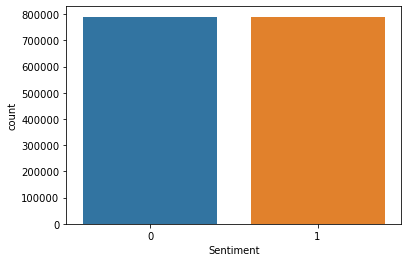

In [9]:
sns.countplot(messages['Sentiment'])

Text(0.5, 0, 'Length of the Tweets')

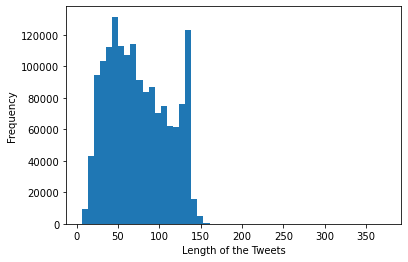

In [10]:
messages['length'].plot(bins=50, kind='hist') 
plt.xlabel('Length of the Tweets')

In [11]:
messages.length.describe()

count    1.578612e+06
mean     7.462829e+01
std      3.613583e+01
min      6.000000e+00
25%      4.400000e+01
50%      7.000000e+01
75%      1.040000e+02
max      3.740000e+02
Name: length, dtype: float64

The maximum length of the tweets is 374. Let's see what that tweet is 

In [12]:
messages[messages['length'] == 374]['SentimentText'].iloc[0]

'@catfish_ohm à¹€à¸„à¹‰à¸²à¹ƒà¸«à¹‰à¸?à¸²à¸£à¹Œà¸•à¸¹à¸™à¸?à¸¸à¹‚à¸£à¸°(à¸ªà¸±à¸ªà¹†+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹„à¸”à¹‰à¹?à¸—à¸™à¸™à¸°à¸žà¸\xadà¸”à¸µà¸¡à¸´à¹‚à¸?à¸°à¸«à¸§à¸‡(à¸‚à¸™à¸²à¸”à¹€à¸Ÿà¸´à¸™à¹?à¸?à¸¢à¸±à¸‡à¹€à¸„à¸¢à¹ƒà¸«à¹‰à¹„à¸¡à¹ˆà¹ƒà¸Šà¹ˆà¹€à¸«à¸£à¸\xad.à¹?à¸•à¹ˆà¸Šà¹ˆà¸²à¸‡à¹€à¸«à¸\xadà¸°à¸£à¸²à¸¢à¸™à¸±à¹‰à¸™à¹€à¸‚à¸²à¹‚à¸¡à¹€à¸\xadà¸°à¸?à¸§à¹ˆà¸²à¸›à¸¥à¸²à¹?à¸¡à¸§à¹€à¸¢à¸\xadà¸° = '

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

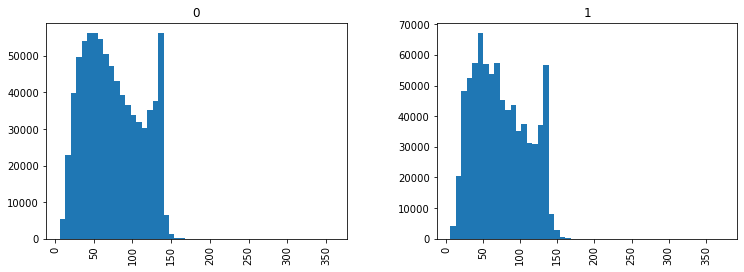

In [13]:
messages.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

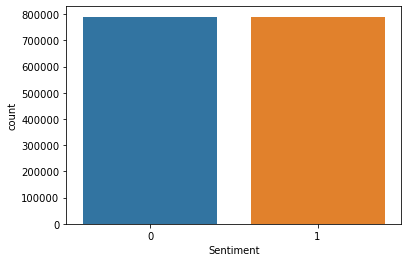

In [14]:
sns.countplot(messages['Sentiment'])

In [15]:
n = (len(messages[messages['Sentiment'] == 0])/len(messages))*100
n

49.944824947485515

In [16]:
p = (len(messages[messages['Sentiment'] == 1])/len(messages))*100
p

50.055175052514485

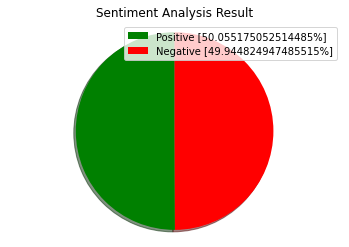

In [17]:
labels = ['Positive ['+str(p)+'%]' ,'Negative ['+str(n)+'%]']
sizes = [p, n]
colors = ['green','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90,shadow=True)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result")
plt.axis('equal')
plt.show()

In [18]:
print(pearsonr(messages['length'],messages['Sentiment']))

(-0.011232976285413889, 3.120074564252326e-45)


## Preprocessing of the Data

In [19]:
messages.drop(['ItemID','SentimentSource'],axis=1,inplace=True)

In [20]:
messages.head()

,Sentiment,SentimentText,length
0,0,is so sad for my APL frie...,61
1,0,I missed the New Moon trail...,51
2,1,omg its already 7:30 :O,37
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,132
4,0,i think mi bf is cheating on me!!! ...,53


In [21]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

As the dataset is too big for us to train on our Local Machine we are Slicing the Data

In [22]:
messages = messages.sample(n=50000)
messages.reset_index(inplace=True)
messages

,index,Sentiment,SentimentText,length
0,260048,0,@kimgasm i wanna visit youuu! I need moneys,44
1,904527,1,I'm in Aldershot waiting for my bestest matey ...,93
2,75295,1,@BTUB40 if I was only a few miles nearer!! Tha...,64
3,1063997,1,@mikerdzign You going next Thursday too? If so...,98
4,1106752,1,no tests,9
...,...,...,...,...
49995,1027209,0,just woke up day off and need to go in to work...,134
49996,679593,0,"Gah, I really hate it when my posts get Stumbl...",116
49997,969885,1,@LAL_rk_JB YAYYYYYYYY!!!!!!!!!!!!! good job la...,52
49998,1275389,0,Trying to focus n do this scholarship but I'm ...,79


In [23]:
pos = messages[messages['Sentiment'] == 1]['SentimentText']

In [24]:
positive = pos.reset_index()['SentimentText']

In [25]:
pos_join = []
for i in range(len(positive)):
    sent = re.sub('[^a-zA-Z]',' ',positive[i])
    pos_join.append(sent)

In [26]:
neg = messages[messages['Sentiment'] == 0]['SentimentText']

In [27]:
negative = neg.reset_index()['SentimentText']

In [28]:
neg_join = []
for i in range(len(negative)):
    sent = re.sub('[^a-zA-Z]',' ',negative[i])
    neg_join.append(sent)

In [29]:
neg_joinget = []
for i in range(len(neg_join)):
    sent = re.sub('get',' ',neg_join[i])
    neg_joinget.append(sent)

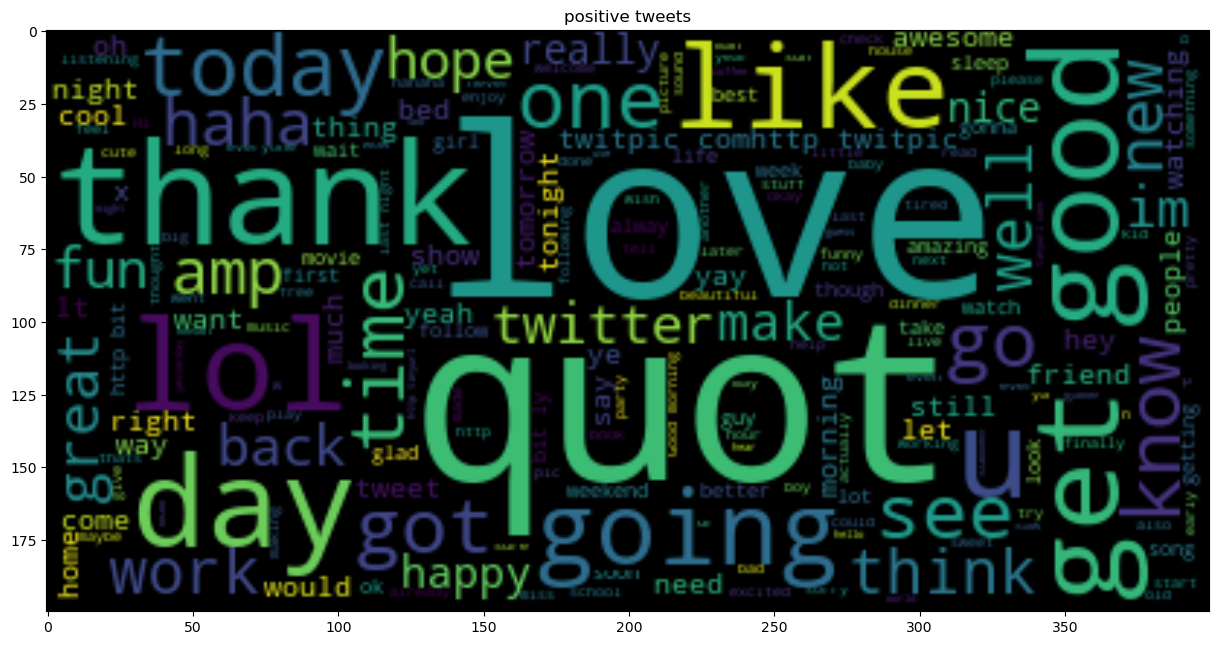

In [30]:
from wordcloud import WordCloud
text_pos = " ".join(x for x in pos_join)
wordcloud = WordCloud(stopwords=stopwords.words('english')).generate(text_pos)
plt.figure(figsize=(15,15))
plt.title('positive tweets')
plt.imshow(wordcloud, interpolation='bilinear')

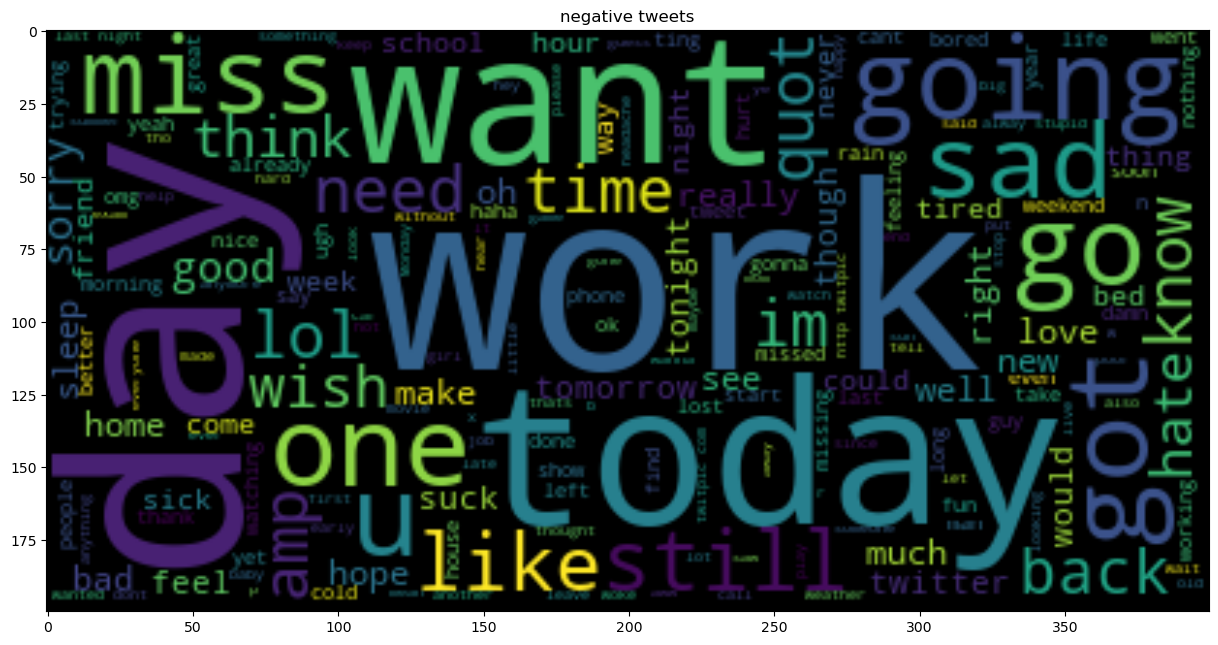

In [31]:
from wordcloud import WordCloud
text_neg = " ".join(x for x in neg_joinget)
wordcloud = WordCloud(stopwords=stopwords.words('english')).generate(text_neg)
plt.figure(figsize=(15,15))
plt.title('negative tweets')
plt.imshow(wordcloud, interpolation='bilinear')

In [32]:
lem = WordNetLemmatizer()

In [33]:
clean_data = []
for i in range(len(messages)):
    sent = re.sub('[^a-zA-Z]',' ',messages['SentimentText'][i])
    sent = sent.lower()
    sent = sent.split()
    sent = [lem.lemmatize(word) for word in sent if word not in stopwords.words('english')]
    sent = ' '.join(sent)
    clean_data.append(sent)
    #if i%1000==0:
    #    print(i)

In [34]:
counts_nsw = collections.Counter(clean_data)
counts_nsw.most_common(15)

[('', 18),
 ('tired', 7),
 ('miss', 5),
 ('follower', 4),
 ('headache', 4),
 ('happy', 4),
 ('work', 4),
 ('fuck', 4),
 ('goodnight', 4),
 ('feeling well', 3),
 ('rain rain go away', 3),
 ('bored work', 3),
 ('missed', 3),
 ('cold', 3),
 ('day', 3)]

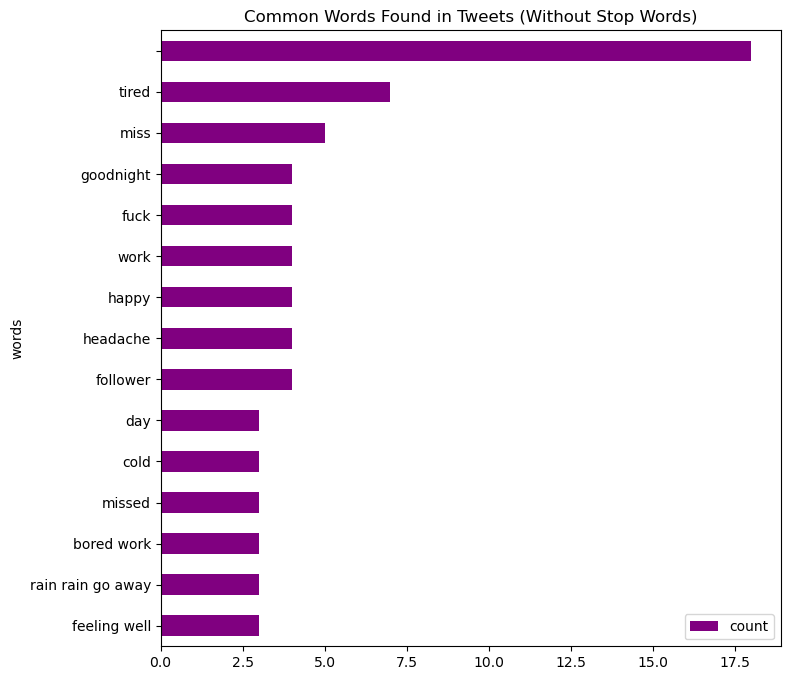

In [35]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

## 3) Converting words into Vectors

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000)

In [37]:
X = tf.fit_transform(clean_data).toarray()

In [38]:
X = pd.concat([pd.DataFrame(X),messages['length']],axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [39]:
y = pd.get_dummies(messages['Sentiment'],drop_first=True)

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4) Training and testing on different Models

### Naive Bayes

In [42]:
from sklearn.naive_bayes import MultinomialNB

In [43]:
log = MultinomialNB(alpha=1.5)

In [44]:
log.fit(X_train,y_train)

MultinomialNB(alpha=1.5)

In [45]:
y_pred = log.predict(X_test)

In [57]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

In [50]:
print("LR Accuracy  score = {:.2f}".format(accuracy_score(y_test,y_pred)*100))

LR Accuracy  score = 74.56


In [53]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3676 1309]
 [1235 3780]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      4985
           1       0.74      0.75      0.75      5015

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



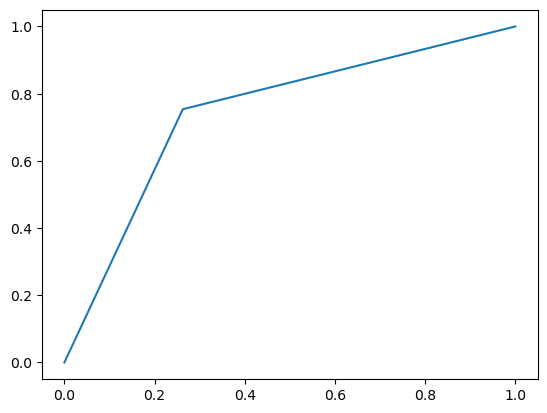

In [55]:
nb_acc = accuracy_score(y_test,y_pred)
nb_acc

fpr,tpr,_=roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)

In [56]:
grid_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False],  
}

In [57]:
clf = GridSearchCV(log, grid_params)
clf.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(alpha=1.5),
             param_grid={'alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'fit_prior': [True, False]})

In [58]:
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.7403000000000001
Best Params:  {'alpha': 1.5, 'fit_prior': True}


In [82]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3676 1309]
 [1235 3780]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      4985
           1       0.74      0.75      0.75      5015

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



### Logistic Regression 

In [59]:
LR = LogisticRegression(random_state = 0,max_iter=1000)
LR.fit(X_train, y_train)
y_pred_lr = LR.predict(X_test)
LR_score = accuracy_score(y_test,y_pred)
print("LR Accuracy  score = {:.2f}".format(LR_score*100))

LR Accuracy  score = 74.56


In [61]:
print(confusion_matrix(y_test,y_pred_lr))
print(classification_report(y_test,y_pred_lr))

[[3637 1348]
 [1129 3886]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      4985
           1       0.74      0.77      0.76      5015

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



0.7523


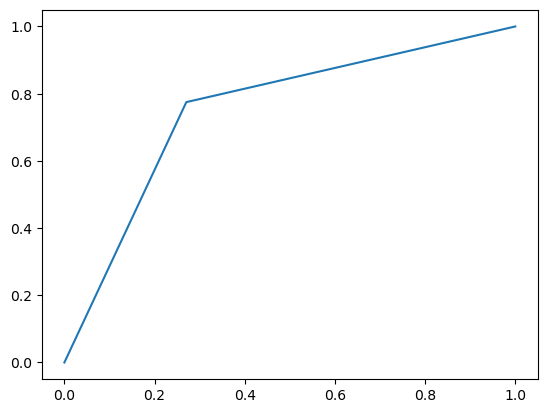

In [64]:
lr_acc = accuracy_score(y_test,y_pred_lr)
print(lr_acc)

fpr,tpr,_=roc_curve(y_test,y_pred_lr)
plt.plot(fpr,tpr)

## Deep Learning

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
model = Sequential()
model.add(Dense(units=480,activation='relu'))
model.add(Dense(units=240,activation='relu'))
model.add(Dense(units=120,activation='relu'))
model.add(Dense(units=60,activation='relu'))
model.add(Dense(units=30,activation='relu'))
model.add(Dense(units=15,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [73]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [74]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
1250/1250 [==============================] - 16s 12ms/step - loss: 0.1431 - val_loss: 2.2188
Epoch 2/600
1250/1250 [==============================] - 16s 13ms/step - loss: 0.1244 - val_loss: 1.8843
Epoch 3/600
1250/1250 [==============================] - 24s 20ms/step - loss: 0.1242 - val_loss: 1.6597
Epoch 4/600
1250/1250 [==============================] - 15s 12ms/step - loss: 0.1159 - val_loss: 1.9942
Epoch 5/600
1250/1250 [==============================] - 16s 13ms/step - loss: 0.1079 - val_loss: 1.8750
Epoch 6/600
1250/1250 [==============================] - 24s 19ms/step - loss: 0.1020 - val_loss: 2.3150
Epoch 7/600
1250/1250 [==============================] - 15s 12ms/step - loss: 0.1031 - val_loss: 2.0710
Epoch 8/600
1250/1250 [==============================] - 18s 14ms/step - loss: 0.1000 - val_loss: 1.9244
Epoch 00008: early stopping


<AxesSubplot:>

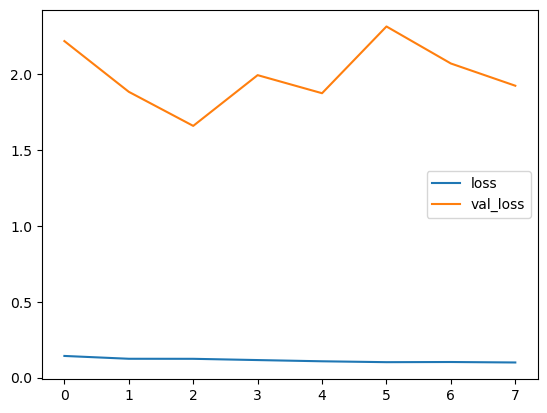

In [75]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [76]:
predictions = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [83]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3541 1444]
 [1605 3410]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      4985
           1       0.70      0.68      0.69      5015

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



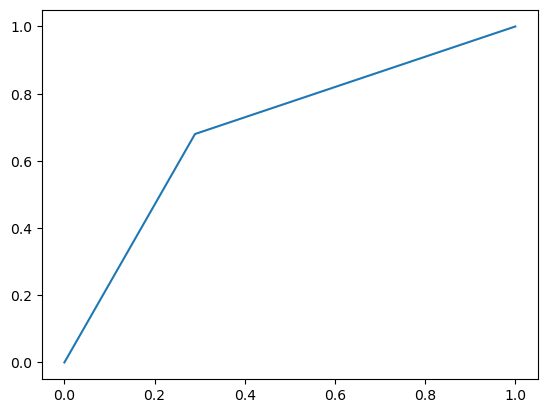

In [81]:
ann_acc = accuracy_score(y_test,predictions)
ann_acc

fpr,tpr,_=roc_curve(y_test,predictions)
plt.plot(fpr,tpr)

In [80]:
Predictive_models = pd.DataFrame({
    'Model': ['LR', 'NB', 'ANN'],
    'Accuracy': [lr_acc, nb_acc, ann_acc]})
Predictive_models.sort_values(by ='Accuracy', ascending=False)

,Model,Accuracy
0,LR,0.7523
1,NB,0.7456
2,ANN,0.6951


# Thank you